In [1]:
import geopandas as gpd

In [2]:
gdf_celdas = gpd.read_parquet("outputs/gdf_celdas_final_2025_06_17.parquet")
gdf_celdas.head()

,cell_id,category,country,pop_total,pop_primary_school_age,pop_middle_school_age,pop_secondary_school_age,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,duration_to_nearest_primary_schools_label,distance_to_nearest_middle_schools,duration_to_nearest_middle_schools,duration_to_nearest_middle_schools_label,distance_to_nearest_secondary_schools,duration_to_nearest_secondary_schools,duration_to_nearest_secondary_schools_label,geometry
0,13887,urban_area,bol,0.000000,0.000000,0.000000,0.000000,1.6730,20.075000,15-30,1.6730,20.075000,15-30,1.6730,20.075000,15-30,"POLYGON ((-69.57156 -10.95204, -69.57038 -10.9..."
1,13956,non_urban_area,bol,0.205296,0.071269,0.068739,0.069190,1.0347,12.415000,0-15,1.0347,12.415000,0-15,1.0347,12.415000,0-15,"POLYGON ((-69.21655 -11.14754, -69.21536 -11.1..."
2,13993,non_urban_area,bol,4.057443,1.408542,1.358551,1.367463,0.2030,2.436667,0-15,0.2030,2.436667,0-15,0.2030,2.436667,0-15,"POLYGON ((-69.06537 -11.28604, -69.06416 -11.2..."
3,13998,non_urban_area,bol,2.743381,0.952365,0.918565,0.924590,0.5786,6.943333,0-15,0.5786,6.943333,0-15,0.5786,6.943333,0-15,"POLYGON ((-69.02062 -11.18827, -69.01942 -11.1..."
4,14081,non_urban_area,bol,2.388741,0.829252,0.799821,0.805067,0.5990,7.186667,0-15,0.5990,7.186667,0-15,0.5990,7.186667,0-15,"POLYGON ((-68.98432 -11.88112, -68.98305 -11.8..."


In [3]:
gdf_celdas.columns

Index(['cell_id', 'category', 'country', 'pop_total', 'pop_primary_school_age',
       'pop_middle_school_age', 'pop_secondary_school_age',
       'distance_to_nearest_primary_schools',
       'duration_to_nearest_primary_schools',
       'duration_to_nearest_primary_schools_label',
       'distance_to_nearest_middle_schools',
       'duration_to_nearest_middle_schools',
       'duration_to_nearest_middle_schools_label',
       'distance_to_nearest_secondary_schools',
       'duration_to_nearest_secondary_schools',
       'duration_to_nearest_secondary_schools_label', 'geometry'],
      dtype='object')

In [4]:
print("Numer of cells without access:")
(
    gdf_celdas[
        [
            "duration_to_nearest_primary_schools_label",
            "duration_to_nearest_middle_schools_label",
            "duration_to_nearest_secondary_schools_label",
        ]
    ]
    == "No access"
).sum()

Numer of cells without access:


duration_to_nearest_primary_schools_label      1922
duration_to_nearest_middle_schools_label       1169
duration_to_nearest_secondary_schools_label    1701
dtype: int64

In [5]:
gdf_celdas[gdf_celdas["duration_to_nearest_primary_schools_label"] == "No access"][
    "category"
].value_counts()

category
non_urban_area    1731
urban_area         191
Name: count, dtype: int64

In [6]:
import contextily as cx
import numpy as np
from tqdm.auto import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
# Load amazon boundaries
amazon = gpd.read_file("/Users/claudio/Documents/amazonia-bid/inputs/Amazonas")
amazon.crs.to_string()

'ESRI:102033'

In [8]:
# Convert to mercator and get the polygon
amazon_poly = amazon.to_crs(4326).geometry[0]

In [9]:
# Load south american rivers. Source: https://www.hydrosheds.org/products/hydrorivers
south_american_rivers_gdf = gpd.read_parquet(
    "outputs/HydroRIVERS_v10_south_america.parquet"
)
south_american_rivers_gdf.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,60000001,0,60000001,0.97,0.0,6.5,3.73,3.7,0,0.109,1,1,7,6120035220,"LINESTRING (-61.125 14.86667, -61.11875 14.87292)"
1,60000002,0,60000002,1.16,0.0,5.3,4.98,5.0,0,0.147,1,2,7,6120035220,"LINESTRING (-61.11875 14.8625, -61.11875 14.87..."
2,60000003,0,60000003,3.37,0.0,7.2,8.09,7.5,0,0.217,1,1,7,6120035220,"LINESTRING (-61.15208 14.85, -61.15208 14.8645..."
3,60000004,0,60000004,3.37,0.0,6.3,11.41,11.2,0,0.329,1,1,7,6120035220,"LINESTRING (-61.17292 14.84583, -61.17292 14.8..."
4,60000005,0,60000005,3.07,0.0,7.9,6.64,6.4,0,0.187,1,1,7,6120035220,"LINESTRING (-61.11667 14.84375, -61.11042 14.8..."


In [10]:
# south_american_rivers_gdf.to_parquet(
#     "outputs/HydroRIVERS_v10_south_america.parquet"
# )

In [11]:
south_american_rivers_gdf.shape

(1620963, 15)

In [12]:
# Filter rivers within Amazon bounds
minx, miny, maxx, maxy = amazon_poly.bounds
amazon_rivers_gdf = south_american_rivers_gdf.cx[minx:maxx, miny:maxy]

In [13]:
# amazon_rivers_gdf.to_parquet(
#     "outputs/HydroRIVERS_v10_amazon.parquet"
# )

In [14]:
# Filter the isolate cells for each edu level
isolated_cells_primary = gdf_celdas[
    gdf_celdas["duration_to_nearest_primary_schools_label"] == "No access"
]
isolated_cells_secondary = gdf_celdas[
    gdf_celdas["duration_to_nearest_secondary_schools_label"] == "No access"
]
isolated_cells_middle = gdf_celdas[
    gdf_celdas["duration_to_nearest_middle_schools_label"] == "No access"
]

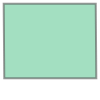

In [15]:
isolated_cells_primary.iloc[100]["geometry"]

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:
polygon_example = isolated_cells_primary.iloc[[100]]

<Axes: >

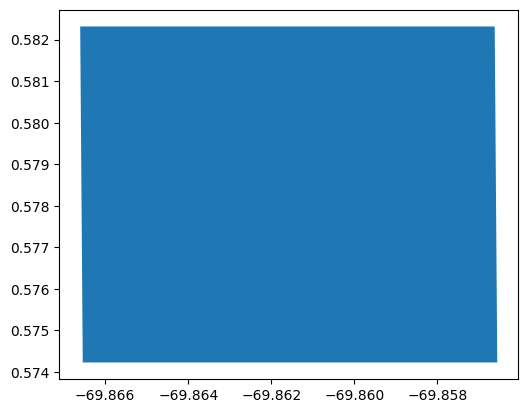

In [18]:
# Plot the polygon with the population data
polygon_example.plot()

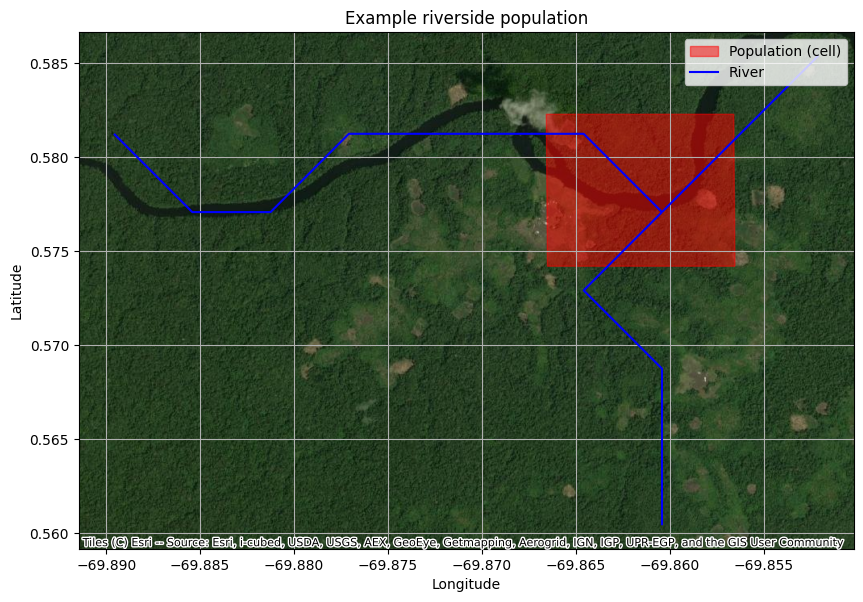

In [19]:
# Visualize the polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
polygon_example.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5)

amazon_rivers_gdf[
    amazon_rivers_gdf.intersects(polygon_example.iloc[0]["geometry"])
].plot(ax=ax, color="blue")

# Add the basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=polygon_example.crs)

# Add the title
ax.set_title("Example riverside population")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

pop_patch = mpatches.Patch(color="red", label="Population (cell)", alpha=0.5)
river_line = mlines.Line2D([], [], color="blue", label="River")

ax.legend(handles=[pop_patch, river_line], loc="upper right")

# Show the plot
plt.show()

In [20]:
import osmnx as ox

In [21]:
isolated_cells_primary_proj = ox.project_gdf(isolated_cells_primary)
isolated_cells_middle_proj = ox.project_gdf(isolated_cells_middle)
isolated_cells_secondary_proj = ox.project_gdf(isolated_cells_secondary)
amazon_rivers_gdf_proj = amazon_rivers_gdf.to_crs(
    isolated_cells_primary_proj.crs.to_string()
)

In [22]:
isolated_cells_primary_wrivers_proj = isolated_cells_primary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [23]:
isolated_cells_primary_wrivers_proj.shape[0], isolated_cells_primary_proj.shape[0]

(1919, 1922)

In [24]:
isolated_cells_primary_wrivers_proj.distance_to_river.isna().sum()

np.int64(588)

In [25]:
isolated_cells_secondary_wrivers_proj = isolated_cells_secondary_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [26]:
isolated_cells_middle_wrivers_proj = isolated_cells_middle_proj.sjoin_nearest(
    amazon_rivers_gdf_proj,
    how="left",
    max_distance=100,
    distance_col="distance_to_river",  # 1km
).drop_duplicates(subset="cell_id")

In [40]:
isolated_cells_primary_wrivers_proj

,cell_id,category,country,pop_total,pop_primary_school_age,pop_middle_school_age,pop_secondary_school_age,distance_to_nearest_primary_schools,duration_to_nearest_primary_schools,duration_to_nearest_primary_schools_label,...,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,distance_to_river
61,14243,non_urban_area,bol,0.000000,0.000000,0.000000,0.000000,0.0,0.0,No access,...,99.0,23.95,2462.5,0.0,30.954,5.0,5.0,5.0,6.120581e+09,0.0
62,14244,non_urban_area,bol,0.390922,0.130375,0.131199,0.129429,0.0,0.0,No access,...,99.0,23.95,2462.5,0.0,30.954,5.0,5.0,5.0,6.120581e+09,0.0
254,14806,non_urban_area,bol,19.360972,6.721164,6.482622,6.525146,0.0,0.0,No access,...,435.0,6.11,13618.8,0.0,302.992,5.0,5.0,4.0,6.120511e+09,0.0
255,14807,non_urban_area,bol,37.551329,13.035948,12.573288,12.655765,0.0,0.0,No access,...,435.0,6.11,13618.8,0.0,302.992,5.0,5.0,4.0,6.120511e+09,0.0
270,14842,non_urban_area,bol,0.479630,0.166504,0.160594,0.161648,0.0,0.0,No access,...,25.4,30.03,94.3,0.0,2.020,2.0,7.0,6.0,6.121171e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35208,35477,non_urban_area,bra,86.500083,29.331085,28.972714,29.744861,NaN,NaN,No access,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35209,35478,non_urban_area,bra,63.682124,21.593804,21.329967,21.898429,NaN,NaN,No access,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35210,35490,non_urban_area,bra,170.997419,57.983065,57.274618,58.801035,NaN,NaN,No access,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35211,35491,non_urban_area,bra,105.967342,35.932186,35.493162,36.439089,NaN,NaN,No access,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

data = {
    "Level": ["Primary", "Middle", "Secondary"],
    "Total isolated (= No Access)": [
        isolated_cells_primary_proj.shape[0],
        isolated_cells_middle_proj.shape[0],
        isolated_cells_secondary_proj.shape[0],
    ],
    "Not near river": [
        isolated_cells_primary_wrivers_proj.distance_to_river.isna().sum(),
        isolated_cells_middle_wrivers_proj.distance_to_river.isna().sum(),
        isolated_cells_secondary_wrivers_proj.distance_to_river.isna().sum(),
    ],
    "Near river": [
        isolated_cells_primary_wrivers_proj.distance_to_river.notna().sum(),
        isolated_cells_middle_wrivers_proj.distance_to_river.notna().sum(),
        isolated_cells_secondary_wrivers_proj.distance_to_river.notna().sum(),
    ],
}

df_summary = pd.DataFrame(data)
df_summary["% Not near river"] = round(
    100 * df_summary["Not near river"] / df_summary["Total isolated (= No Access)"], 2
)
df_summary

,Level,Total isolated (= No Access),Not near river,Near river,% Not near river
0,Primary,1922,588,1331,30.59
1,Middle,1169,341,821,29.17
2,Secondary,1701,501,1195,29.45


In [ ]:
# Calculate total population for each education level and river proximity
levels = ["Primary", "Middle", "Secondary"]
pop_columns = [
    (
        "isolated_cells_primary",
        "isolated_cells_primary_wrivers_proj",
        "pop_primary_school_age",
    ),
    (
        "isolated_cells_middle",
        "isolated_cells_middle_wrivers_proj",
        "pop_middle_school_age",
    ),
    (
        "isolated_cells_secondary",
        "isolated_cells_secondary_wrivers_proj",
        "pop_secondary_school_age",
    ),
]
results = []
for level, (iso_name, wriver_name, pop_col) in zip(levels, pop_columns):
    iso = globals()[iso_name]
    wriver = globals()[wriver_name]
    # Isolated: sum of pop_total in all isolated cells
    pop_isolated = iso[pop_col].sum()
    # Not near river: sum of pop_total where distance_to_river isna()
    pop_not_near_river = wriver[wriver["distance_to_river"].isna()][pop_col].sum()
    # Near river: sum of pop_total where distance_to_river is notna()
    pop_near_river = wriver[wriver["distance_to_river"].notna()][pop_col].sum()
    results.append(
        [level, int(pop_isolated), int(pop_not_near_river), int(pop_near_river)]
    )

df_pop_summary = pd.DataFrame(
    results,
    columns=[
        "Level",
        "Total isolated population",
        "Not near river population",
        "Near river population",
    ],
)
df_pop_summary

,Level,Total isolated population,Not near river population,Near river population
0,Primary,25105,9974,15130
1,Middle,24832,11237,13592
2,Secondary,21761,9530,12230


In [ ]:
print("Downloading OSM water geometry… this can take several minutes.")
water = ox.features_from_polygon(amazon_poly, tags=tags)

In [ ]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import shape, box

###############################################################################
# 1. Build / load a polygon for “the Amazon”
###############################################################################

# -- Option A -------------------------------------------------------------
# An approximate bounding box (very coarse but quick to set up)
#   west, south, east, north
amazon_poly = box(-74.0, -20.0, -44.0, 6.0)

# -- Option B -------------------------------------------------------------
# Use a high-quality polygon: e.g. WWF’s Amazon biome shapefile
# (download once from https://databasin.org/ or https://www.worldwildlife.org/)
# amazon_biome = gpd.read_file("amazon_biome_WWF.shp").geometry.unary_union
# amazon_poly  = amazon_biome  # a (Multi)Polygon

###############################################################################
# 2. Query OpenStreetMap for anything that is water
###############################################################################

# Tags that map to **area** water features in OSM
tags = {
    "natural": ["water", "wetland"],
    "waterway": "riverbank",  # rivers mapped as polygons
    "landuse": "reservoir",
    "water": True,  # catches many named waterbodies
}

print("Downloading OSM water geometry… this can take several minutes.")
water = ox.features_from_polygon(amazon_poly, tags=tags)

###############################################################################
# 3. Keep only polygons & multipolygons (drop LineStrings such as river centre-lines)
###############################################################################

water_polys = water[water.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

###############################################################################
# 4. Reproject to match your study grid (here: `cells`)
###############################################################################

cells = gpd.read_file("cells_500m_buffer.gpkg")  # your 500 m grid
water_polys = water_polys.to_crs(cells.crs)

# (optional) dissolve everything into a single multipolygon for fast spatial tests
water_union = water_polys.geometry.unary_union

###############################################################################
# Done – you now have `water_polys` (one row per waterbody)
# or `water_union` (one big multipolygon) ready for intersects/within/overlay
###############################################################################